In [63]:
import pandas as pd
import numpy as np
# import plotly.express as px
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.utils import shuffle

In [18]:
data = pd.read_csv('data/data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


## Анализ

In [19]:
data.drop(['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1',
                  'coeff_sum0', 'coeff_sum1'], axis=1, inplace=True)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


In [7]:
# контекстные фичи:
#  date_time
#  zone_id
#  zone_id

# фичи рекламного предложени
#  banner_id
#  impressions
#  
#  clicks - target

# фичи юзера
#  os_id
#  country_id

In [20]:
data_with_no_impressions = data[ data['impressions'] == 0 ]

In [21]:
data_with_no_impressions.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks


In [22]:
data.drop('impressions', axis=1, inplace=True)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1


Столбец impressions состоит только из 1, можно он не несет никакой информации, удалил

(array([6302714., 1403934.,  388801., 3492759., 1525569.,  649215.,
         568735.,  478038.,  329240.,  682467.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

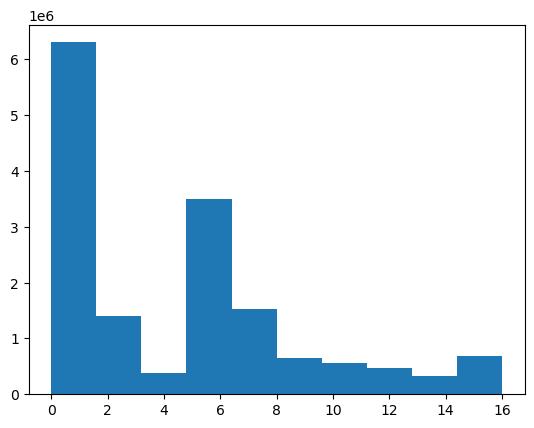

In [23]:
# fig_country_id = px.histogram(data, x="country_id")
# fig_country_id.show()
plt.hist(data['country_id'])

(array([3.856798e+06, 3.178693e+06, 4.589979e+06, 7.597670e+05,
        3.012541e+06, 1.119460e+05, 3.103460e+05, 9.900000e+01,
        1.273000e+03, 3.000000e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

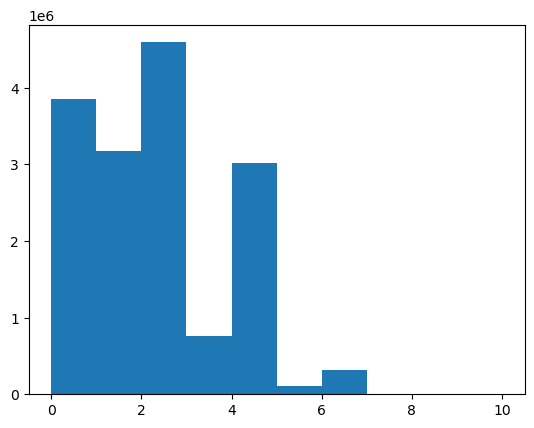

In [24]:
# fig_os_id = px.histogram(data, x="os_id")
# fig_os_id.show()
plt.hist(data['os_id'])

In [25]:
data.os_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

(array([15399223.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,   422249.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

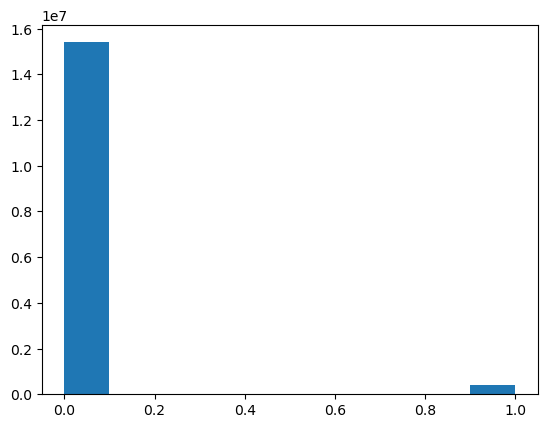

In [26]:
# fig_clicks = px.histogram(data, x="clicks")
# fig_clicks.show()
plt.hist(data['clicks'])

In [27]:
data['date'] = data['date_time'].apply(lambda s: s.split()[0])

In [28]:
data['time'] = data['date_time'].apply(lambda s: s.split()[1])

In [30]:
data.drop('date_time', axis=1, inplace=True)
data.head()

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,date,time
0,0,0,0,0,0,1,2021-09-27,00:01:30.000000
1,1,1,0,0,1,1,2021-09-26,22:54:49.000000
2,2,2,3,0,0,1,2021-09-26,23:57:20.000000
3,3,3,0,1,1,1,2021-09-27,00:04:30.000000
4,4,4,0,1,0,1,2021-09-27,00:06:21.000000


,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks
0,0,0,0,0,0,1
1,1,1,0,0,1,1
2,2,2,3,0,0,1
3,3,3,0,1,1,1
4,4,4,0,1,0,1


(array([2.367303e+06, 3.102610e+06, 2.420588e+06, 0.000000e+00,
        1.851189e+06, 2.307355e+06, 0.000000e+00, 1.643448e+06,
        2.128978e+06, 1.000000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

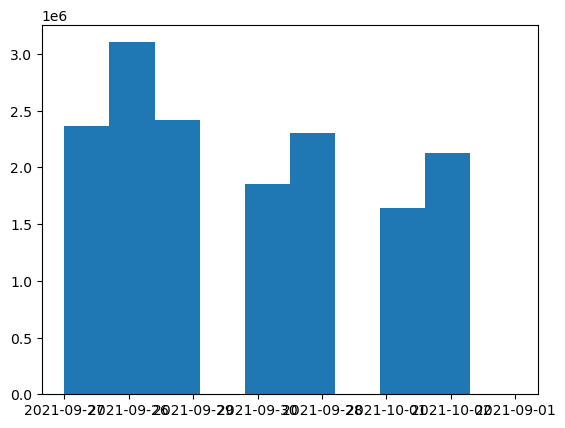

In [31]:
# fig_clicks = px.histogram(data, x="date")
# fig_clicks.show()
plt.hist(data['date'])

Если нарисовать в plotly, то видно только 7 столбцов и смещение, у нас мало данных с 1 сентября

In [32]:
data.date.unique()

array(['2021-09-27', '2021-09-26', '2021-09-29', '2021-09-30',
       '2021-09-28', '2021-10-01', '2021-10-02', '2021-09-01'],
      dtype=object)

In [33]:
data[ data.date == '2021-09-01' ]

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,date,time
1390198,30,596,0,0,7,0,2021-09-01,00:02:49.000000


In [35]:
data.drop(data.index[[1390198]], inplace=True)

Удалим этот выброс

(array([2367303., 3102610.,       0., 2420588.,       0., 1851189.,
        2307355.,       0., 1643448., 2128978.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

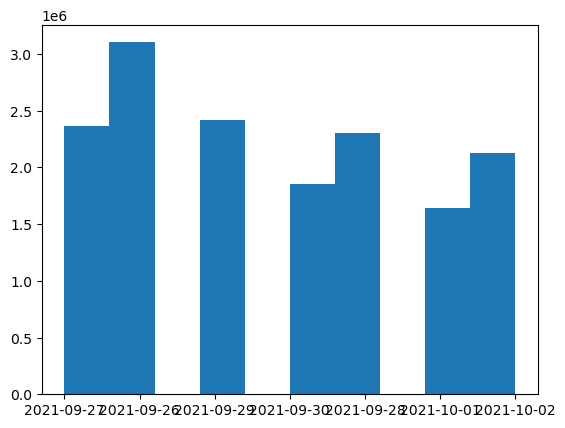

In [40]:
# fig_clicks = px.histogram(data, x="date")
# fig_clicks.show()
plt.hist(data['date'])

In [38]:
len(data.zone_id.unique())

3444

In [39]:
len(data.banner_id.unique())

1633

## Анализ
* zone_id, banner_id, os_id, country_id - категориальные фичи, onehotencoding применим для них
* clicks - target
* date_time разделил на два столбца date и time - предлагаю оставить только цифру дня, часы, минуты и секунды. А после этого применить sin и cos, чтобы расстрояние между 30 сентября и 1 октября были близкими (с временем так стандартно работают)
* Был выброс по дате 2021-09-01
* Был вырожденный стобец показов


## feature_engineering

In [68]:
data.head()

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,date,time
0,0,0,0,0,0,1,2021-09-27,00:01:30.000000
1,1,1,0,0,1,1,2021-09-26,22:54:49.000000
2,2,2,3,0,0,1,2021-09-26,23:57:20.000000
3,3,3,0,1,1,1,2021-09-27,00:04:30.000000
4,4,4,0,1,0,1,2021-09-27,00:06:21.000000


In [69]:
data.to_csv('data01.csv', index=False)

In [82]:
data = pd.read_csv('data01.csv')

In [83]:
data.head()

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,date,time
0,0,0,0,0,0,1,2021-09-27,00:01:30.000000
1,1,1,0,0,1,1,2021-09-26,22:54:49.000000
2,2,2,3,0,0,1,2021-09-26,23:57:20.000000
3,3,3,0,1,1,1,2021-09-27,00:04:30.000000
4,4,4,0,1,0,1,2021-09-27,00:06:21.000000


In [84]:
data['date'] = data['date'].apply(lambda s: int(s.split('-')[2]))
data['hour'] = data['time'].apply(lambda s: int(float(s.split(':')[0])))
data['minute'] = data['time'].apply(lambda s: int(float(s.split(':')[1])))
data['second'] = data['time'].apply(lambda s: int(float(s.split(':')[2])))
data.drop('time', axis=1, inplace=True)
data.head()

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,date,hour,minute,second
0,0,0,0,0,0,1,27,0,1,30
1,1,1,0,0,1,1,26,22,54,49
2,2,2,3,0,0,1,26,23,57,20
3,3,3,0,1,1,1,27,0,4,30
4,4,4,0,1,0,1,27,0,6,21


In [85]:
data.date.unique()

array([27, 26, 29, 30, 28,  1,  2])

In [86]:
# l_hour = data.hour.unique().tolist()
# l_hour.sort()
# l_hour

In [87]:
# l_minute = data.minute.unique().tolist()
# l_minute.sort()
# l_minute

In [88]:
# l_second = data.second.unique().tolist()
# l_second.sort()
# l_second

In [89]:
data['date_sin'] = np.sin(data.date*(2.*np.pi/31))
data['date_cos'] = np.cos(data.date*(2.*np.pi/31))

data['hour_sin'] = np.sin(data.hour*(2.*np.pi/24))
data['hour_cos'] = np.cos(data.hour*(2.*np.pi/24))

data['minute_sin'] = np.sin((data.minute-1)*(2.*np.pi/60))
data['minute_cos'] = np.cos((data.minute-1)*(2.*np.pi/60))

data['second_sin'] = np.sin((data.second-1)*(2.*np.pi/60))
data['second_cos'] = np.cos((data.second-1)*(2.*np.pi/60))

In [90]:
# data.drop('date', axis=1, inplace=True)
data.drop('hour', axis=1, inplace=True)
data.drop('minute', axis=1, inplace=True)
data.drop('second', axis=1, inplace=True)
data.head()

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,date,date_sin,date_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
0,0,0,0,0,0,1,27,-0.724793,0.688967,0.000000,1.000000,0.000000,1.000000,0.104528,-0.994522
1,1,1,0,0,1,1,26,-0.848644,0.528964,-0.500000,0.866025,-0.669131,0.743145,-0.951057,0.309017
2,2,2,3,0,0,1,26,-0.848644,0.528964,-0.258819,0.965926,-0.406737,0.913545,0.913545,-0.406737
3,3,3,0,1,1,1,27,-0.724793,0.688967,0.000000,1.000000,0.309017,0.951057,0.104528,-0.994522
4,4,4,0,1,0,1,27,-0.724793,0.688967,0.000000,1.000000,0.500000,0.866025,0.866025,-0.500000


In [91]:
categories = ['zone_id', 'banner_id', 'os_id', 'country_id']

In [92]:
data_categories = data[categories]

In [93]:
encoder = OneHotEncoder()
encoder.fit(data_categories)

OneHotEncoder()

In [94]:
data_categories_encodeed = encoder.transform(data_categories)

In [95]:
data_categories_encodeed.shape

(15821471, 5105)

In [96]:
data.drop(data_categories, axis=1, inplace=True)
data.head()

,campaign_clicks,clicks,date,date_sin,date_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
0,0,1,27,-0.724793,0.688967,0.000000,1.000000,0.000000,1.000000,0.104528,-0.994522
1,0,1,26,-0.848644,0.528964,-0.500000,0.866025,-0.669131,0.743145,-0.951057,0.309017
2,3,1,26,-0.848644,0.528964,-0.258819,0.965926,-0.406737,0.913545,0.913545,-0.406737
3,0,1,27,-0.724793,0.688967,0.000000,1.000000,0.309017,0.951057,0.104528,-0.994522
4,0,1,27,-0.724793,0.688967,0.000000,1.000000,0.500000,0.866025,0.866025,-0.500000


In [97]:
data.shape

(15821471, 11)

In [98]:
dataset = scipy.sparse.hstack([data.drop(['date', 'clicks'], axis=1), data_categories_encodeed])

In [99]:
dataset = dataset.tocsr()

In [100]:
idx_test = data.date == 2
idx_train = data.date != 2

dataset_train = dataset[idx_train]
dataset_test = dataset[idx_test]

In [101]:
y_train = data[idx_train].clicks
y_test = data[idx_test].clicks

In [102]:
dataset_train.shape

(13692493, 5114)

In [103]:
dataset_train, y_train = shuffle(dataset_train, y_train)

## Train
В первом запуске лучшим себя показал параметр C = 0.05, поэтому решил добавить больше параметров вокруг него. 

Основаная модель - Логистическая регрессия.
В качестве оптимайзера взял с лекции ```liblinear```.

In [104]:
def train():
    min_log_loss = 1000000000
    opt_C = 0.0
    opt_model = None
    for C in [0.005, 0.04, 0.05, 0.07, 0.5]:
        model = LogisticRegression(solver='liblinear', C=C)
        cv_results = cross_validate(model, dataset_train, y_train, scoring=['roc_auc', 'neg_log_loss'], cv=3)
        curr_log_loss = -np.mean(cv_results['test_neg_log_loss'])
        curr_auc = np.mean(cv_results['test_roc_auc'])
        print(f'======== C: {C} ========')
        print(f'log_loss: {curr_log_loss}')
        print(f'roc_auc: {curr_auc}')
        if min_log_loss > curr_log_loss:
            min_log_loss = curr_log_loss
            opt_C = C
            opt_model = model
    return opt_model, opt_C

In [105]:
model, C = train()

======== C: 0.005 ========
log_loss: 0.10627489302602362
roc_auc: 0.7530490660544706
======== C: 0.04 ========
log_loss: 0.10539236157662475
roc_auc: 0.7595358155429534
======== C: 0.05 ========
log_loss: 0.10535185344914312
roc_auc: 0.7598172735023221
======== C: 0.07 ========
log_loss: 0.10530214481942728
roc_auc: 0.7601577172842799
======== C: 0.5 ========
log_loss: 0.10517826101265243
roc_auc: 0.7609586271638705


In [106]:
model.fit(dataset_train, y_train)

LogisticRegression(C=0.5, solver='liblinear')

In [107]:
y_pred = model.predict_proba(dataset_test)[:, 1]
my_log_loss = log_loss(y_test, y_pred)
my_auc = roc_auc_score(y_test, y_pred)
print(f'======= Test Metrics =======')
print(f'======= My Model =======')
print(f'log_loss: {my_log_loss}')
print(f'auc: {my_auc}')

======= Test Metrics =======
======= My Model =======
log_loss: 0.1334549924173812
auc: 0.7801157566633397


In [108]:
y_pred_baseline = np.full(y_test.shape, np.mean(y_train))
baseline_log_loss = log_loss(y_test, y_pred_baseline)
baseline_auc = roc_auc_score(y_test, y_pred_baseline)
print(f'======= Baseline =======')
print(f'log_loss: {baseline_log_loss}')
print(f'auc: {baseline_auc}')

======= Baseline =======
log_loss: 0.15486197934508547
auc: 0.5


Наша модель побила baseline